In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

path = "C:\\Users\\Nathan\\Desktop\\Guttenberg Gait Database\\"

# Left 
GRF_F_V_PRO_left = pd.read_csv(os.path.join(path,'GRF_F_V_PRO_left.csv'))
GRF_F_AP_PRO_left = pd.read_csv(os.path.join(path,'GRF_F_AP_PRO_left.csv'))
GRF_F_ML_PRO_left = pd.read_csv(os.path.join(path,'GRF_F_ML_PRO_left.csv'))

# Right lower extremity
GRF_F_V_PRO_right = pd.read_csv(os.path.join(path,'GRF_F_V_PRO_right.csv'))
GRF_F_AP_PRO_right = pd.read_csv(os.path.join(path,'GRF_F_AP_PRO_right.csv'))
GRF_F_ML_PRO_right = pd.read_csv(os.path.join(path,'GRF_F_ML_PRO_right.csv'))

In [2]:
def TransformDataFrame(DataFrame):
    DataFrame = DataFrame.drop(['DATASET_ID', 'SUBJECT_ID', 'SESSION_ID', 'TRIAL_ID'], axis = 1)
    DataFrame = DataFrame.T
    return DataFrame

def SelectSuject(ID, DataLeft, DataRight):
    DataSubjectLeft = DataLeft[DataLeft['SUBJECT_ID'] == ID]
    DataSubjectRight = DataRight[DataRight['SUBJECT_ID'] == ID]
    DataSubjectLeft = TransformDataFrame(DataSubjectLeft)
    DataSubjectRight = TransformDataFrame(DataSubjectRight)
    return DataSubjectLeft, DataSubjectRight

def MeanData(DataLeft, DataRight):
     MeanData = pd.DataFrame()
     MeanData["Left"] =  DataLeft.mean(axis = 1)
     MeanData["Right"] = DataRight.mean(axis = 1)
     return  MeanData["Left"], MeanData["Right"]

def TabGrfTotal(DataSubjectLeft, DataSubjectRight, decalage):
    GrfRight = [-999]
    GrfLeft = [-999]

    SwingLeft = [0] * (100 - (2 *decalage))
    SwingRight = [0] * (100 - (2 *decalage))
    
    for col in zip(DataSubjectLeft.columns, DataSubjectRight.columns):
        GrfLeft = np.concatenate((GrfLeft, DataSubjectLeft[col[0]], SwingLeft), axis = 0)
        GrfRight = np.concatenate((GrfRight, DataSubjectRight[col[1]], SwingRight), axis = 0)

    GrfLeft = GrfLeft[1:]
    GrfRight = GrfRight[1:]
    GrfLeft = GrfLeft[(100 - decalage):]
    GrfRight = GrfRight[ : (len(GrfRight)-(100 - decalage))]
    GrfLeft[:decalage+10] = 0
    GrfRight[-decalage - 102:] = 0
    GrfRight[0] = 0
    
    return GrfLeft, GrfRight

def ConcatenanteGrfTotal(DataSubjectLeft, DataSubjectRight):
    GrfRight = [-999]
    GrfLeft = [-999]
    
    for col in zip(DataSubjectLeft.columns, DataSubjectRight.columns):
        GrfLeft = np.concatenate((GrfLeft, DataSubjectLeft[col[0]]), axis = 0)
        GrfRight = np.concatenate((GrfRight, DataSubjectRight[col[1]]), axis = 0)

    GrfLeft = GrfLeft[1:]
    GrfRight = GrfRight[1:]
    
    return GrfLeft, GrfRight

Si on veut faire du traitement avec tous les pas avec un décalage de temps entre chaque pas cf : 
- attention ça coupe le premier et dernier donc ça fait planter certains codes

In [3]:
""" Choix du patient avec ID puis importation des data depuis la base de donnée de Guttenberg """
ID = 1
decalage_entre_deux_pas = 15

VerticalGrfLeft, VerticalGrfRight = SelectSuject(ID, DataLeft = GRF_F_V_PRO_left, DataRight = GRF_F_V_PRO_right)
VerticalGrfLeft, VerticalGrfRight = TabGrfTotal(DataSubjectLeft = VerticalGrfLeft, DataSubjectRight = VerticalGrfRight, decalage = decalage_entre_deux_pas)

ApGrfLeft, ApGrfRight = SelectSuject(ID, DataLeft = GRF_F_AP_PRO_left, DataRight = GRF_F_AP_PRO_right)
ApGrfLeft, ApGrfRight = TabGrfTotal(DataSubjectLeft = ApGrfLeft, DataSubjectRight = ApGrfRight, decalage = decalage_entre_deux_pas)

MediolateralGrfLeft, MediolateralGrfRight = SelectSuject(ID, DataLeft = GRF_F_ML_PRO_left, DataRight = GRF_F_ML_PRO_right)
MediolateralGrfLeft, MediolateralGrfRight = TabGrfTotal(DataSubjectLeft = MediolateralGrfLeft, DataSubjectRight = MediolateralGrfRight, decalage = decalage_entre_deux_pas)


""" Création et implémentation de l'objet Walking avec des semelles """
# from semelle_connecte.SOLE.FeetMe import FeetMe
# from semelle_connecte.Walking.Walking import Walking
from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking

dataLeft = pd.DataFrame()
dataLeft["VerticalVGrf"] = VerticalGrfLeft
dataLeft["ApGrf"] = ApGrfLeft
dataLeft["MediolateralGrf"] = MediolateralGrfLeft

SoleInstanceLeft = FeetMe(100)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = VerticalGrfRight
dataRight["ApGrf"] = ApGrfRight
dataRight["MediolateralGrf"] = MediolateralGrfRight

SoleInstanceRight = FeetMe(100)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass=90)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

In [4]:
####
#### CODE PAS DROIT PUIS GAUCHE PAR EX...
####

Si on veut faire du traitement avec tous les pas sans décalage de temps entre chaque pas cf : 
- évite de couper le premier et dernier pas

In [20]:
""" Choix du patient avec ID puis importation des data depuis la base de donnée de Guttenberg """
ID = 1
decalage_entre_deux_pas = 15

VerticalGrfLeft, VerticalGrfRight = SelectSuject(ID, DataLeft = GRF_F_V_PRO_left, DataRight = GRF_F_V_PRO_right)
VerticalGrfLeft, VerticalGrfRight = ConcatenanteGrfTotal(DataSubjectLeft = VerticalGrfLeft, DataSubjectRight = VerticalGrfRight)

ApGrfLeft, ApGrfRight = SelectSuject(ID, DataLeft = GRF_F_AP_PRO_left, DataRight = GRF_F_AP_PRO_right)
ApGrfLeft, ApGrfRight = ConcatenanteGrfTotal(DataSubjectLeft = ApGrfLeft, DataSubjectRight = ApGrfRight)

MediolateralGrfLeft, MediolateralGrfRight = SelectSuject(ID, DataLeft = GRF_F_ML_PRO_left, DataRight = GRF_F_ML_PRO_right)
MediolateralGrfLeft, MediolateralGrfRight = ConcatenanteGrfTotal(DataSubjectLeft = MediolateralGrfLeft, DataSubjectRight = MediolateralGrfRight)


""" Création et implémentation de l'objet Walking avec des semelles """
# from semelle_connecte.SOLE.FeetMe import FeetMe
# from semelle_connecte.Walking.Walking import Walking
from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking

dataLeft = pd.DataFrame()
dataLeft["VerticalVGrf"] = VerticalGrfLeft
dataLeft["ApGrf"] = ApGrfLeft
dataLeft["MediolateralGrf"] = MediolateralGrfLeft

SoleInstanceLeft = FeetMe(100)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = VerticalGrfRight
dataRight["ApGrf"] = ApGrfRight
dataRight["MediolateralGrf"] = MediolateralGrfRight

SoleInstanceRight = FeetMe(100)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass=90)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

In [21]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import GroundReactionForceKinematicsProcedure

procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591


Normalisation des forces de réactions au sol de chaque pas en % de cycle et en % de poids du corps

In [22]:
from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import NormalisationProcedure

procedure = NormalisationProcedure()
WalkingDataProcessingFilter(walking, procedure).run()

#du coup je relance les calculs des valeurs sur les donnés normalisés
procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591


Visualisation des datas trouvés par la procédure GroundReactionForceKinematicsProcedure() sur les GRF correspondantes :

Pas numéro 1


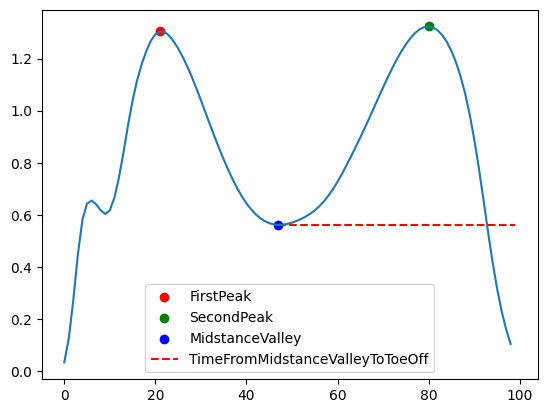

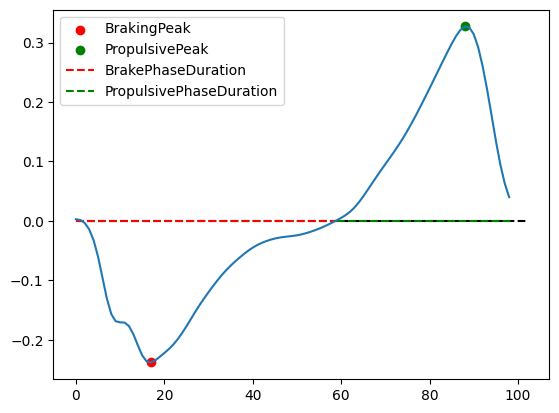

Pas numéro 10


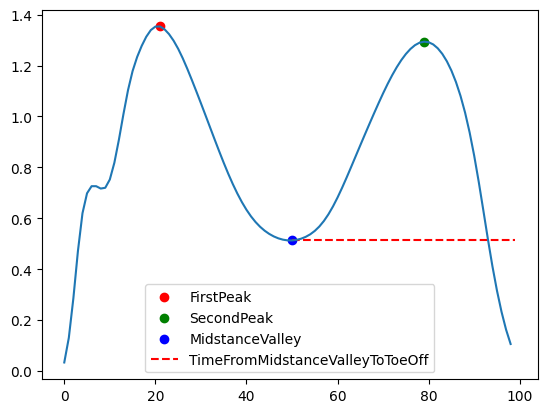

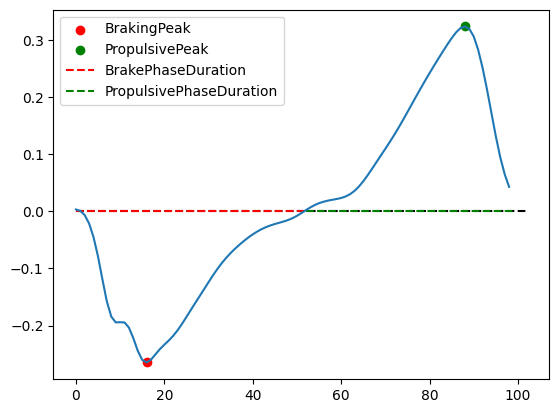

Pas numéro 20


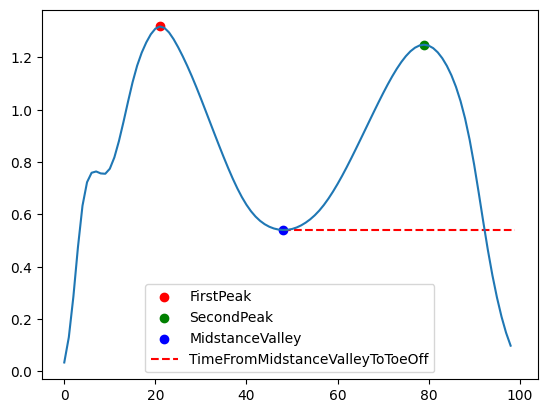

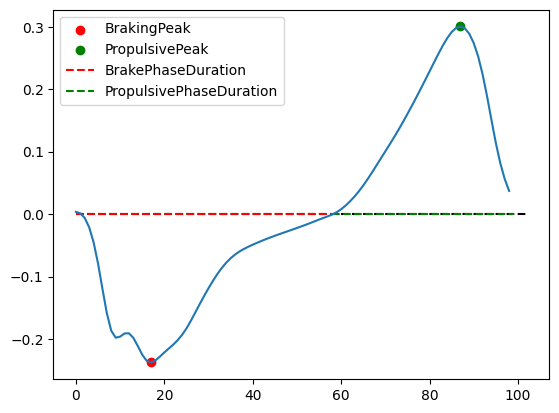

Pas numéro 30


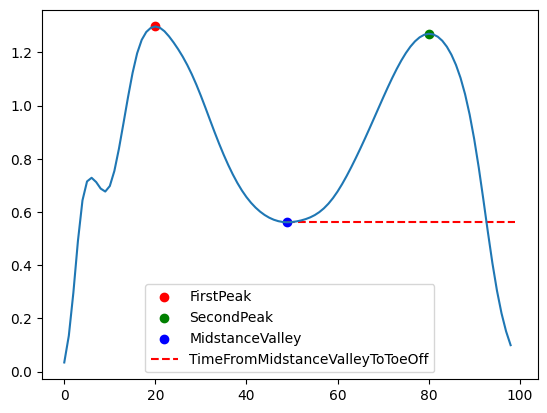

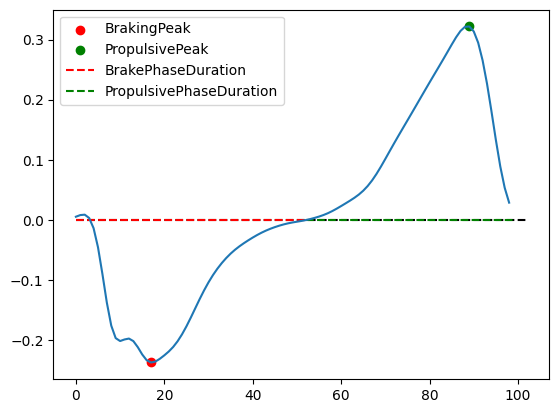

Pas numéro 40


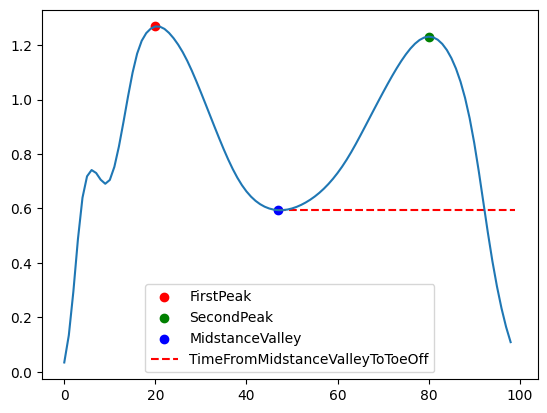

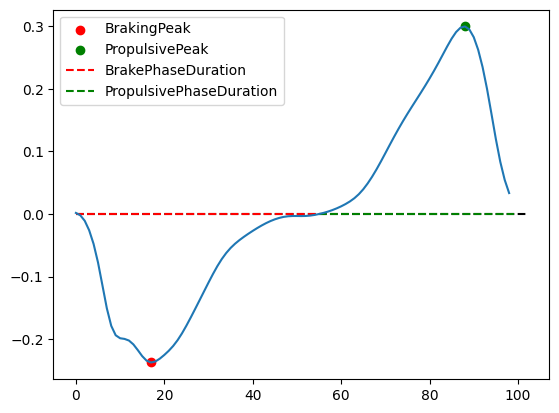

In [23]:
for stepindex in [1,10,20,30,40] :
# for stepindex in np.arange(len(walking.m_StepGrfValue['LeftLeg']['VerticalGrf']) - 1) : # plot tout les pas avec les data trouvés
    """ Visualisation des valeurs retrouvées par GroundReactionForceKinematicsProcedure() """
    FrameRate = 10
    step = stepindex
    print(f"Pas numéro {step}")

    """ Vertical Ground Reaction Force Data """ 

    FirstPeak = walking.m_GroundReactionForces["LeftLeg"][step][0]
    MidstanceValley = walking.m_GroundReactionForces["LeftLeg"][step][1]
    SecondPeak = walking.m_GroundReactionForces["LeftLeg"][step][2]
    FirtPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][3] * FrameRate
    MidstanceValleyTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][4] * FrameRate
    SecondPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][5] * FrameRate
    TimeFromMidstanceValleyToToeOff = walking.m_GroundReactionForces["LeftLeg"][step][6] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['VerticalGrf'][step])
    plt.scatter(x=FirtPeakTimeTo ,y=FirstPeak, c ="r", label="FirstPeak")
    plt.scatter(x=SecondPeakTimeTo ,y=SecondPeak, c="g", label="SecondPeak")
    plt.scatter(x=MidstanceValleyTimeTo ,y=MidstanceValley, c="b", label="MidstanceValley")
    plt.hlines(y=MidstanceValley, xmin=MidstanceValleyTimeTo, xmax=TimeFromMidstanceValleyToToeOff+MidstanceValleyTimeTo,
            colors ="r", ls="--", label='TimeFromMidstanceValleyToToeOff')
    plt.legend()
    plt.show()


    """ Ant-Post Ground Reaction Force Data """
    BrakingPeak = walking.m_GroundReactionForces["LeftLeg"][step][10]
    PropulsivePeak = walking.m_GroundReactionForces["LeftLeg"][step][11]
    BrakePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][12] * FrameRate
    PropulsivePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][13] * FrameRate
    BrakePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][14] * FrameRate
    PropulsivePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][15] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['ApGrf'][step])
    plt.scatter(x= BrakePhaseTimeTo, y=BrakingPeak, c="r", label='BrakingPeak')
    plt.scatter(x= PropulsivePhaseTimeTo + BrakePhaseDuration, y=PropulsivePeak, c="g", label='PropulsivePeak')
    plt.hlines(y=0, xmin=0, xmax=102, colors ="black", ls="--")
    plt.hlines(y=0, xmin=0, xmax=BrakePhaseDuration, colors ="r", ls="--", label='BrakePhaseDuration')
    plt.hlines(y=0, xmin=BrakePhaseDuration, xmax=BrakePhaseDuration + PropulsivePhaseDuration, colors ="g", ls="--", label='PropulsivePhaseDuration')
    plt.legend()
    plt.show()

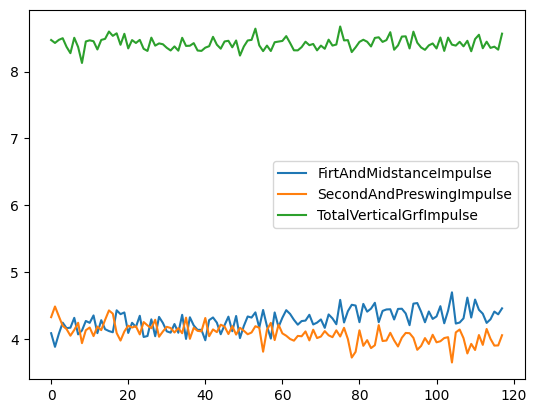

In [9]:
FirtAndMidstanceImpulse = []
SecondAndPreswingImpulse = []
TotalVerticalGrfImpulse = []

for step in np.arange(len(walking.m_GroundReactionForces["LeftLeg"]) - 1):
    FirtAndMidstanceImpulse.append(walking.m_GroundReactionForces["LeftLeg"][step][7])
    SecondAndPreswingImpulse.append(walking.m_GroundReactionForces["LeftLeg"][step][8])
    TotalVerticalGrfImpulse.append(walking.m_GroundReactionForces["LeftLeg"][step][9])

plt.figure()
plt.plot(FirtAndMidstanceImpulse, label="FirtAndMidstanceImpulse")
plt.plot(SecondAndPreswingImpulse, label='SecondAndPreswingImpulse')
plt.plot(TotalVerticalGrfImpulse, label="TotalVerticalGrfImpulse")
plt.legend()
plt.show()

In [10]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import DynamicSymetryFunctionComputeProcedure

procedure = DynamicSymetryFunctionComputeProcedure()
WalkingKinematicsFilter(walking, procedure).run()

A METTRE EN PROCEDURE :

Score d'asymétrie :
-valeur positive = valeur jambe droite > valeur jambe gauche
-valeur négative = valeur jambe gauche > valeur jambe droite
Le pas le plus asymétrique sur le paramètre PropulsiveImpulse est le pas numéro 67


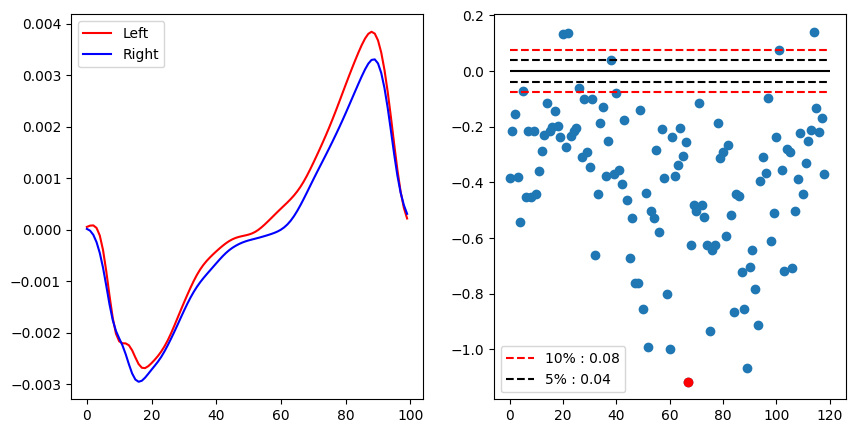

Le pas le moins asymétrique sur le paramètre PropulsiveImpulse est le pas numéro 38


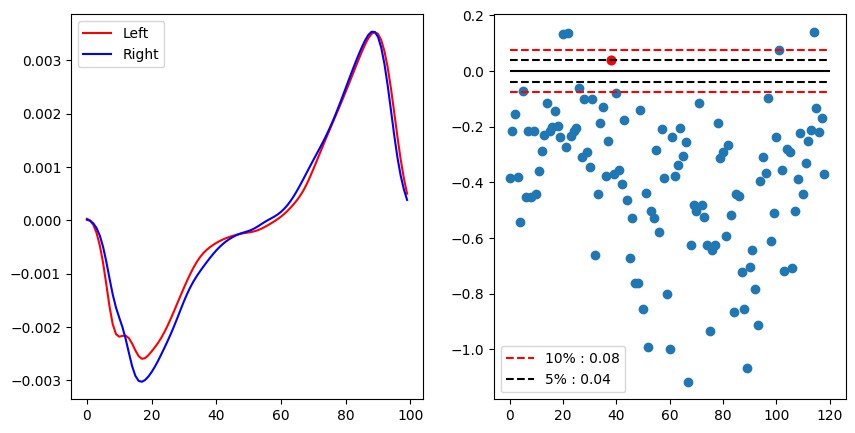

In [11]:
""" 1) Faits un plots de l'asymétrie d'un des paramètres de ground reaction force au cours du temps 
    2) Recherche le pas ou l'asymétrie sur ce paramètre est la plus importante et le plot
    3) Recherche le pas ou l'asymétrie sur ce paramètre est la moins importante et le plot
            Args name and num :
    0 : FirtPeak                                    10 : BrakingPeak
    1 : MidstanceValley                             11 : PropulsivePeak
    2 : SecondPeak                                  12 : BrakePhaseDuration
    3 : FirtPeakTimeTo                              13 : PropulsivePhaseDuration
    4 : MidstanceValleyTimeTo                       14 : BrakePhaseTimeTo
    5 : SecondPeakTimeTo                            15 : PropulsivePhaseTimeTo
    6 : TimeFromMidstanceValleyToToeOff             16 : BrakingImpulse
    7 : FirtAndMidstanceImpulse                     17 : PropulsiveImpulse
    8 : SecondAndPreswingImpulse
    9 : TotalVerticalGrfImpulse 
"""
name = 'PropulsiveImpulse'
num = 17
axe = "ApGrf"
# axe = "VerticalGrf"

listvalue = []
for step in np.arange(len(walking.m_GroundReactionForces['LeftLeg'])):
    listvalue.append(walking.m_GroundReactionForces['LeftLeg'][step][num])
for step in np.arange(len(walking.m_GroundReactionForces['RightLeg'])):
    listvalue.append(walking.m_GroundReactionForces['RightLeg'][step][num])

thresfold5 = max([abs(val) for val in listvalue]) * 5/100
thresfold10 = max([abs(val) for val in listvalue]) * 10/100


StepAsymMax = [val ** 2 for val in walking.m_DataFrameDynamicSymetryScore[name]]
StepAsymMax = np.asarray(StepAsymMax)
StepAsymMax = StepAsymMax.argmax()

print("Score d'asymétrie :")
print("-valeur positive = valeur jambe droite > valeur jambe gauche")
print("-valeur négative = valeur jambe gauche > valeur jambe droite")
print(f"Le pas le plus asymétrique sur le paramètre {name} est le pas numéro {StepAsymMax}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(walking.m_StepGrfValue["LeftLeg"][axe][StepAsymMax], c='r', label='Left')
plt.plot(walking.m_StepGrfValue["RightLeg"][axe][StepAsymMax], c='blue', label='Right')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(x = np.arange(len(walking.m_DataFrameDynamicSymetryScore[name])),
            y = walking.m_DataFrameDynamicSymetryScore[name])
plt.hlines(y= thresfold10, xmin=0, xmax=120, colors='red', ls='--', label=f"10% : {round(thresfold10,2)}")
plt.hlines(y= thresfold5, xmin=0, xmax=120, colors='black', ls='--', label=f"5% : {round(thresfold5,2)}")
plt.hlines(y= 0, xmin=0, xmax=120, colors='black')
plt.hlines(y= - thresfold5, xmin=0, xmax=120, colors='black', ls='--')
plt.hlines(y= - thresfold10, xmin=0, xmax=120, colors='red', ls='--')
plt.scatter(x= StepAsymMax, y= walking.m_DataFrameDynamicSymetryScore[name][StepAsymMax], c='r')
plt.legend()
plt.show()

StepAsymMin = [val ** 2 for val in walking.m_DataFrameDynamicSymetryScore[name]]
StepAsymMin = np.asarray(StepAsymMin)
StepAsymMin = StepAsymMin.argmin()
print(f"Le pas le moins asymétrique sur le paramètre {name} est le pas numéro {StepAsymMin}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(walking.m_StepGrfValue["LeftLeg"][axe][StepAsymMin], c='r', label='Left')
plt.plot(walking.m_StepGrfValue["RightLeg"][axe][StepAsymMin], c='blue', label='Right')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(x = np.arange(len(walking.m_DataFrameDynamicSymetryScore[name])),
            y = walking.m_DataFrameDynamicSymetryScore[name])
plt.hlines(y= thresfold10, xmin=0, xmax=120, colors='red', ls='--', label=f"10% : {round(thresfold10,2)}")
plt.hlines(y= thresfold5, xmin=0, xmax=120, colors='black', ls='--', label=f"5% : {round(thresfold5,2)}")
plt.hlines(y= 0, xmin=0, xmax=120, colors='black')
plt.hlines(y= - thresfold5, xmin=0, xmax=120, colors='black', ls='--')
plt.hlines(y= - thresfold10, xmin=0, xmax=120, colors='red', ls='--')
plt.scatter(x= StepAsymMin, y= walking.m_DataFrameDynamicSymetryScore[name][StepAsymMin], c='r')
plt.legend()
plt.show()

Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03783738243827916
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03783928092833823
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03761415532279691
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.037613941033164316
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.037684492585540894
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.037684881212104504


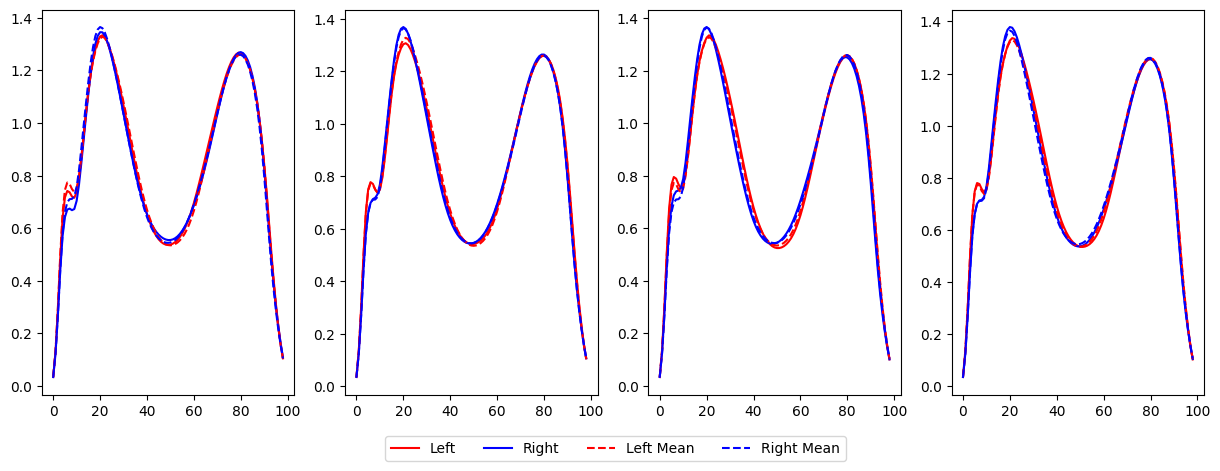

In [12]:
from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import CutDataProcessingProcedure

procedure = CutDataProcessingProcedure()
procedure.setCutNumber(n_cut=4)
WalkingDataProcessingFilter(walking, procedure).run()

from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotCutGroundReactionForceProcedure

procedure = PlotCutGroundReactionForceProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Si on veut qu'une valeur moyenne des pas cf :

In [13]:
ID = 1
decalage_entre_deux_pas = 15

VerticalGrfLeft, VerticalGrfRight = SelectSuject(ID, DataLeft = GRF_F_V_PRO_left, DataRight = GRF_F_V_PRO_right)
VerticalGrfLeft, VerticalGrfRight = MeanData(DataLeft = VerticalGrfLeft, DataRight = VerticalGrfRight)

ApGrfLeft, ApGrfRight = SelectSuject(ID, DataLeft = GRF_F_AP_PRO_left, DataRight = GRF_F_AP_PRO_right)
ApGrfLeft, ApGrfRight  = MeanData(DataLeft = ApGrfLeft, DataRight = ApGrfRight)

MediolateralGrfLeft, MediolateralGrfRight = SelectSuject(ID, DataLeft = GRF_F_ML_PRO_left, DataRight = GRF_F_ML_PRO_right)
MediolateralGrfLeft, MediolateralGrfRight = MeanData(DataLeft = MediolateralGrfLeft, DataRight = MediolateralGrfRight)

In [14]:
# from semelle_connecte.SOLE.FeetMe import FeetMe
# from semelle_connecte.Walking.Walking import Walking
from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking

dataLeft = pd.DataFrame()
dataLeft["VerticalVGrf"] = VerticalGrfLeft.values
dataLeft["ApGrf"] = ApGrfLeft.values
dataLeft["MediolateralGrf"] = MediolateralGrfLeft.values

SoleInstanceLeft = FeetMe(100)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = VerticalGrfRight.values
dataRight["ApGrf"] = ApGrfRight.values
dataRight["MediolateralGrf"] = MediolateralGrfRight.values

SoleInstanceRight = FeetMe(100)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass=90)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

Représenter l'asymétrie d'un pas moyen droit par rapport au gauche dans les trois axes :
- PlotDynamicSymetryFunctionRealtimeProcedure : en temps réel
- PlotDynamicSymetryFunctionNormalised : sur % du cycle 

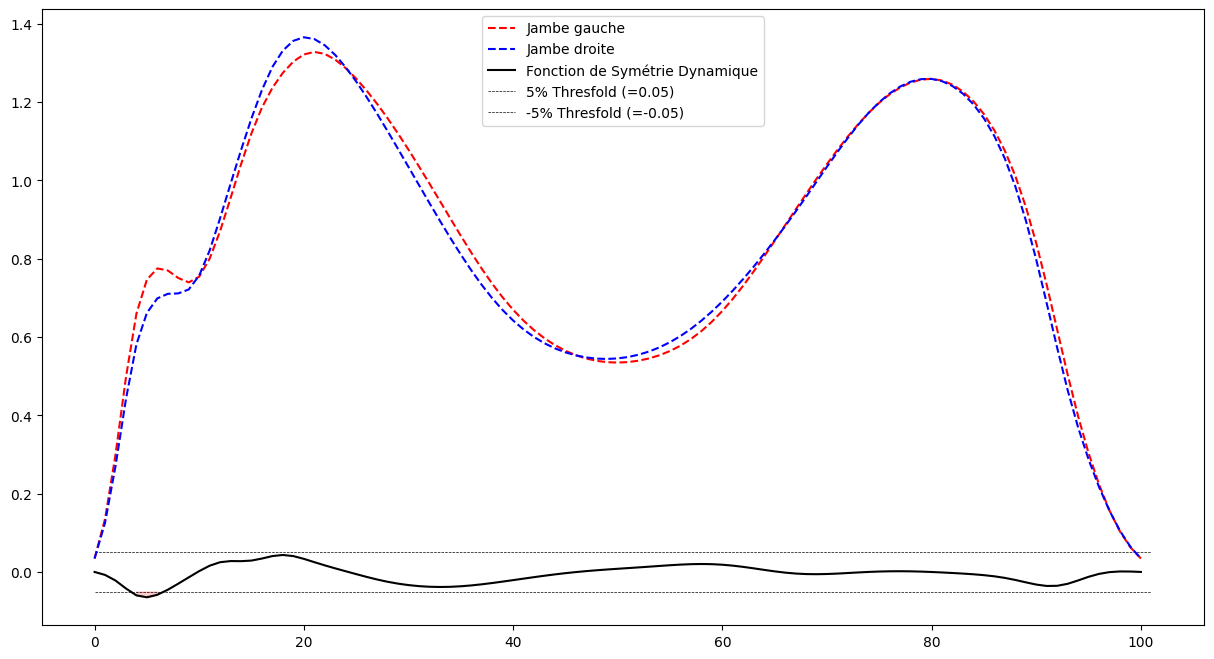

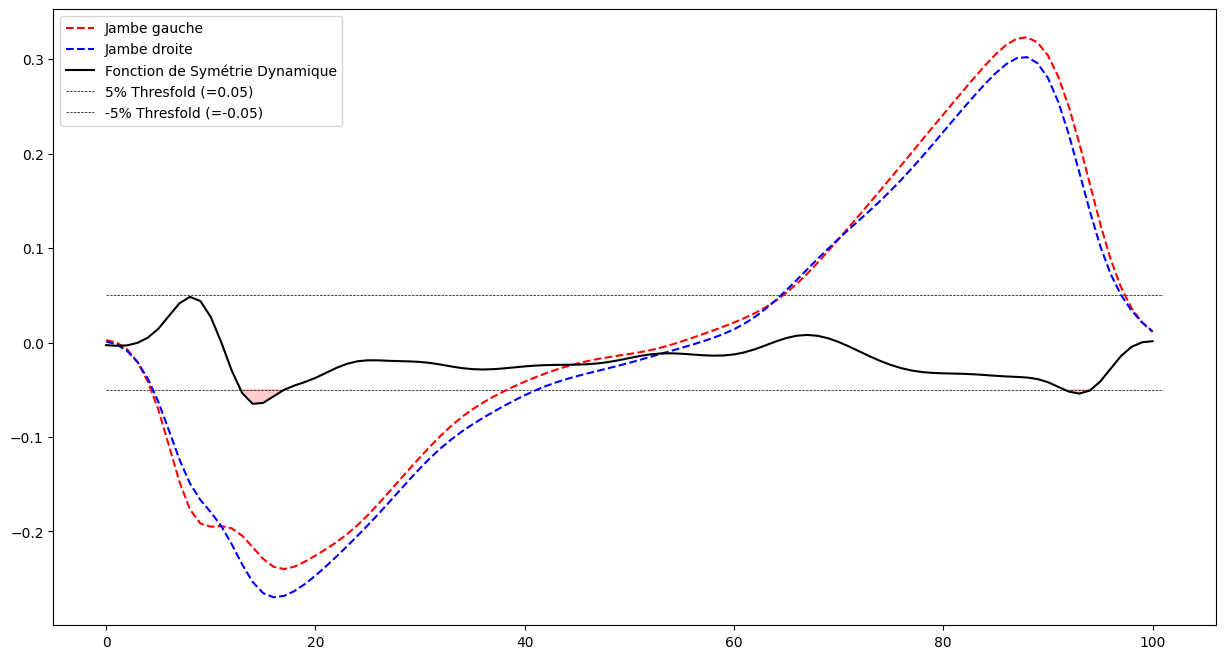

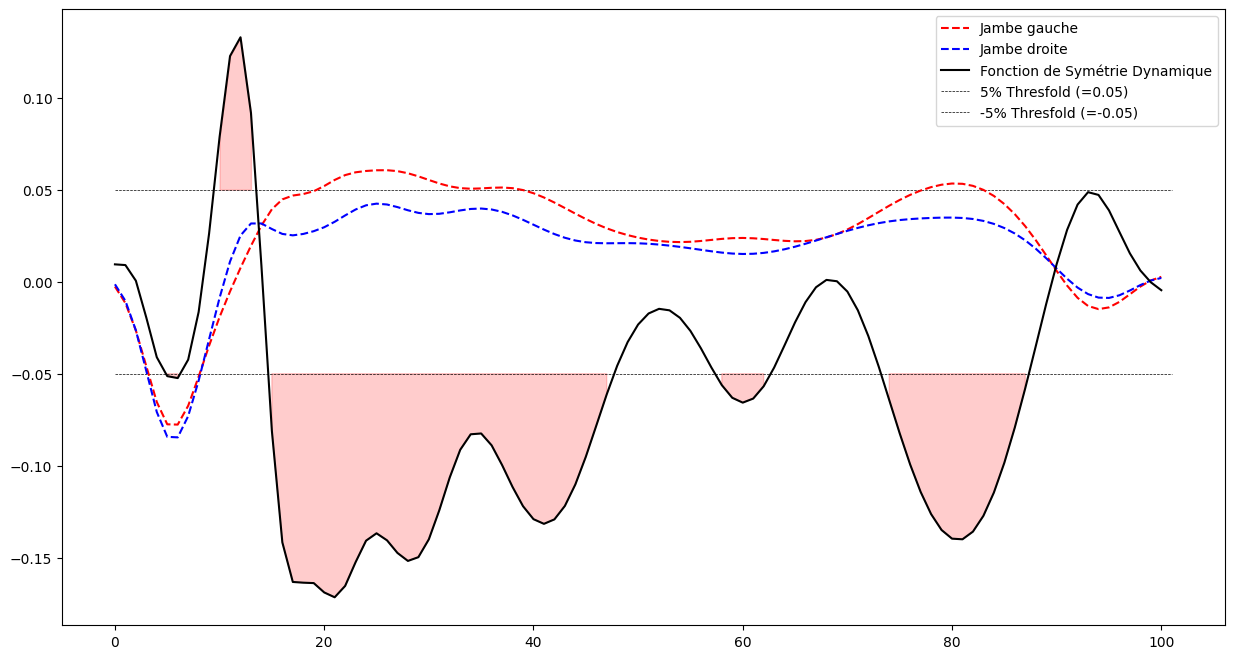

In [15]:
from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotDynamicSymetryFunctionRealtimeProcedure

procedure = PlotDynamicSymetryFunctionRealtimeProcedure()
WalkingGraphicsFilter(walking, procedure).run()

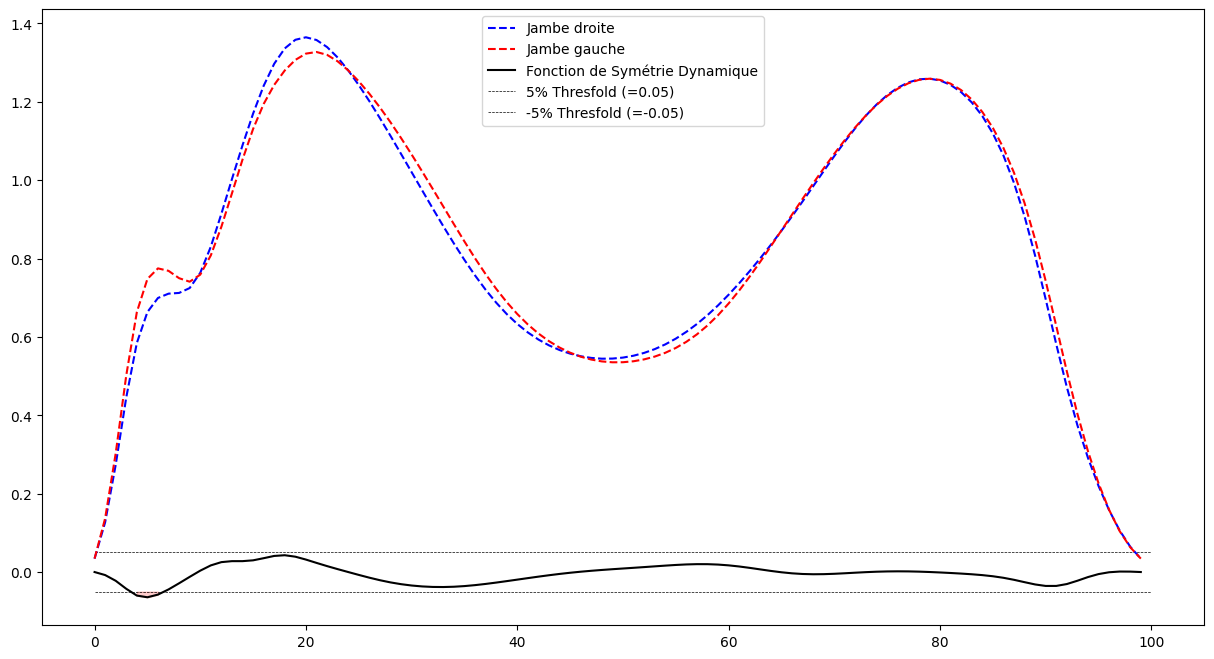

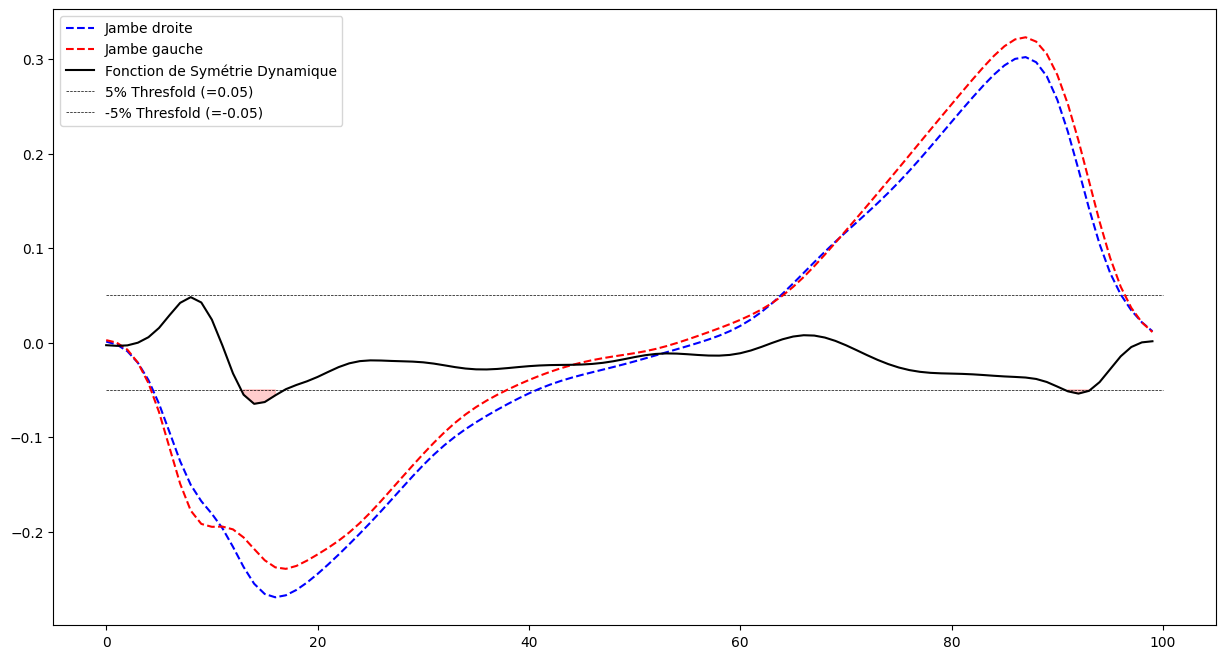

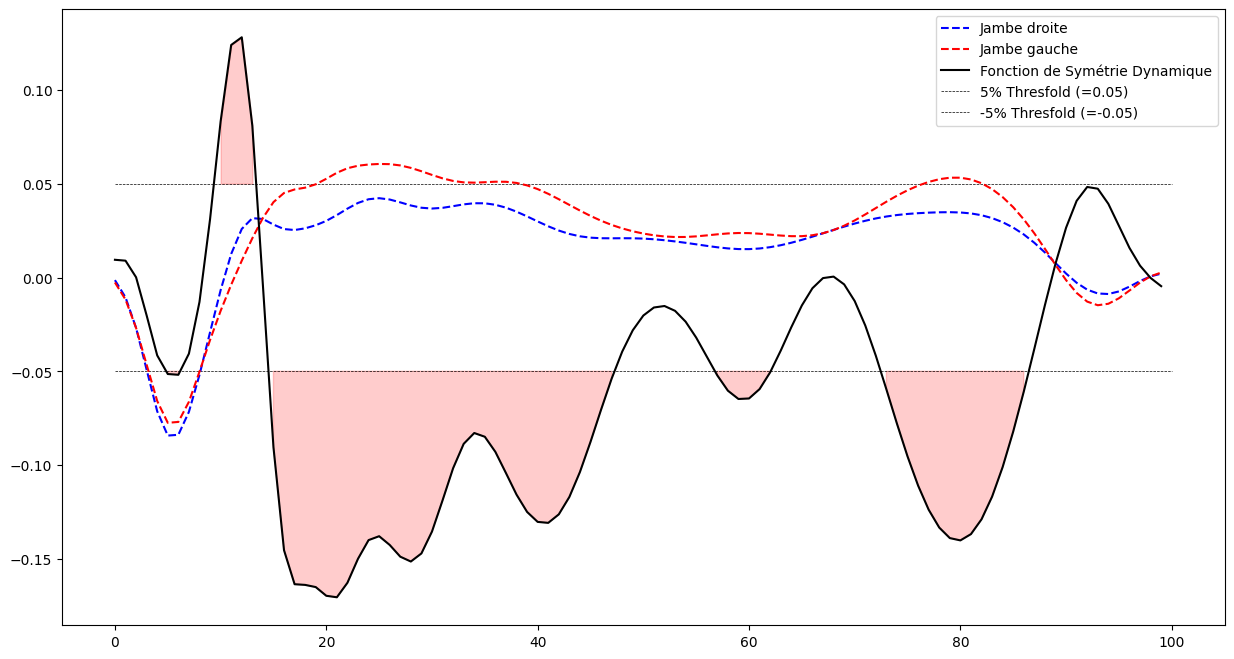

In [16]:
from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotDynamicSymetryFunctionNormalisedProcedure

procedure = PlotDynamicSymetryFunctionNormalisedProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Test gait tracking :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
from Walking.Walking import Walking
walking = Walking(mass=90)

from pyCGM2.Tools import btkTools
from pyCGM2.IMU.BlueTrident import BlueTrident

DataPath = 'C:\\Users\\Nathan\\Desktop\\Wheelchair tests datas\\gait\\'
PathIMULeftLeg = DataPath + 'session102.c3d'
acq = btkTools.smartReader(PathIMULeftLeg)
imuInstance = BlueTrident.getBlueTrident(acq,"8")

walking.setLeftLegIMU(imuInstance)

Error: 45686.885 m


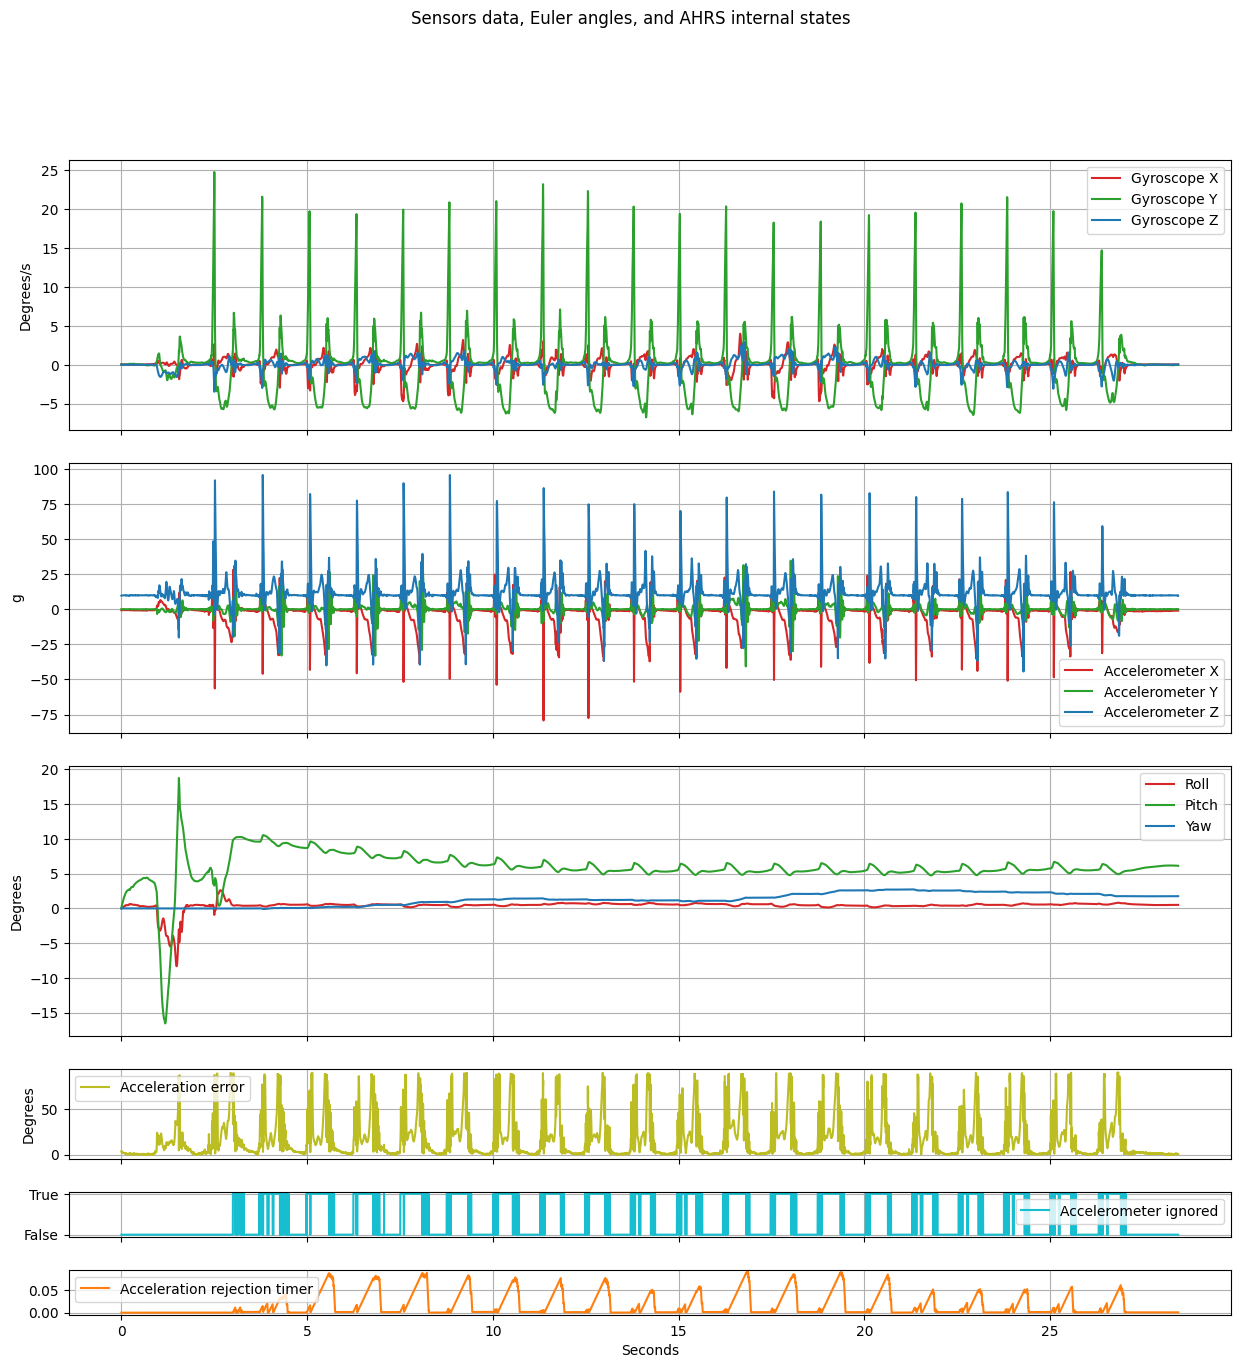

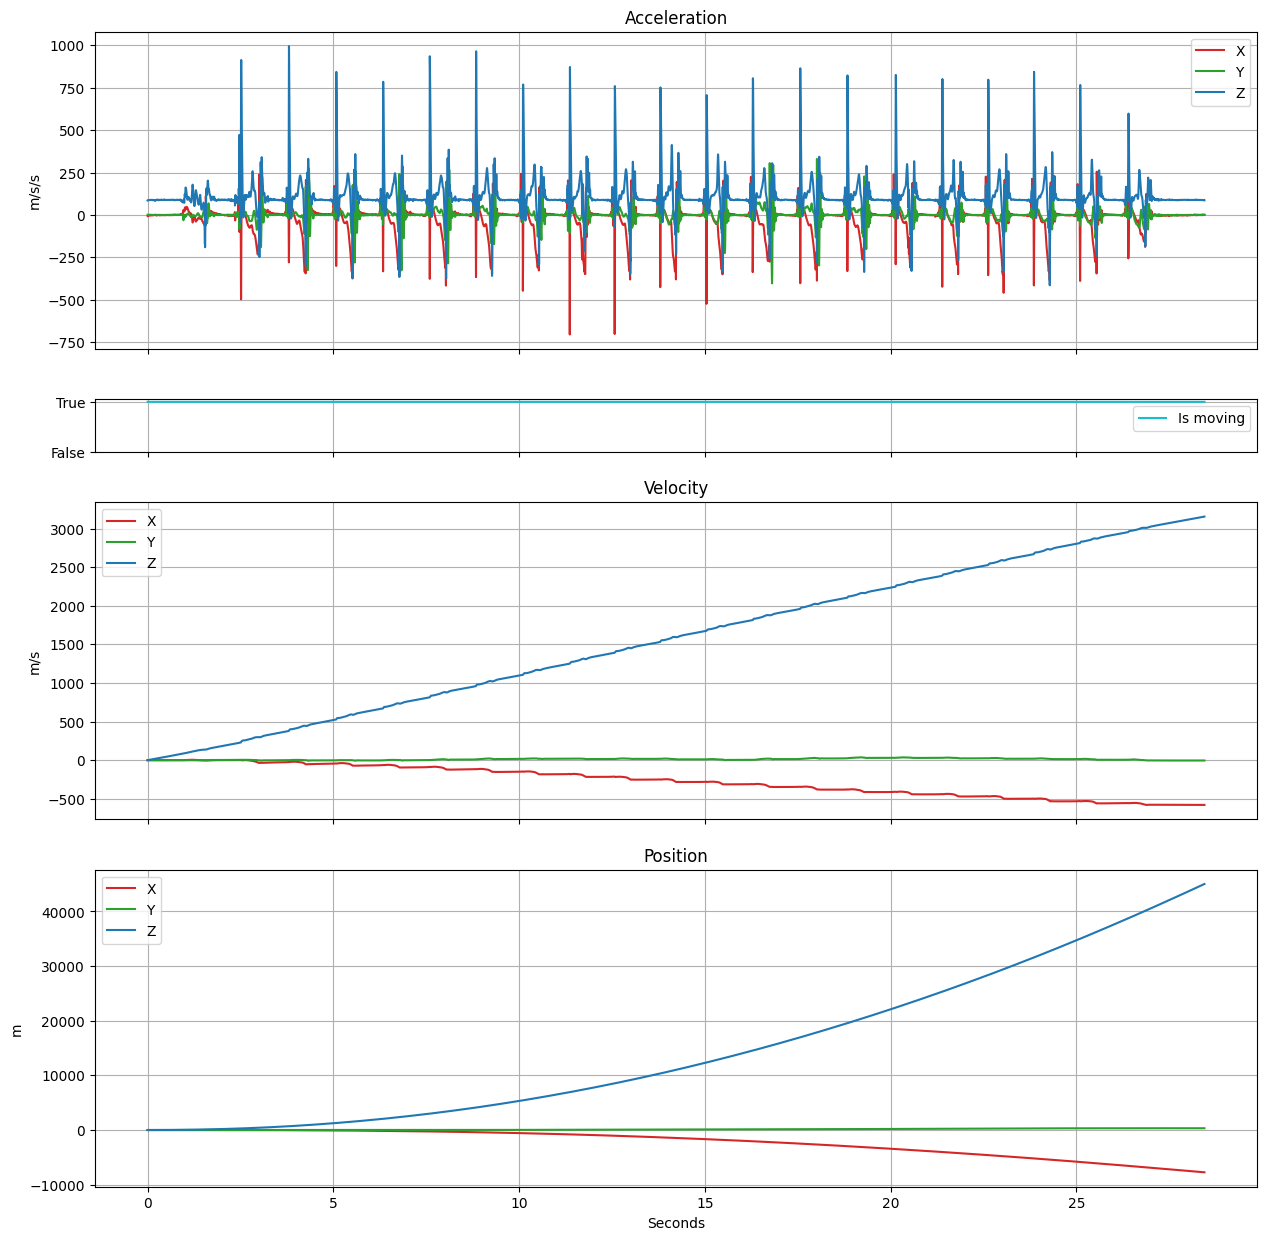

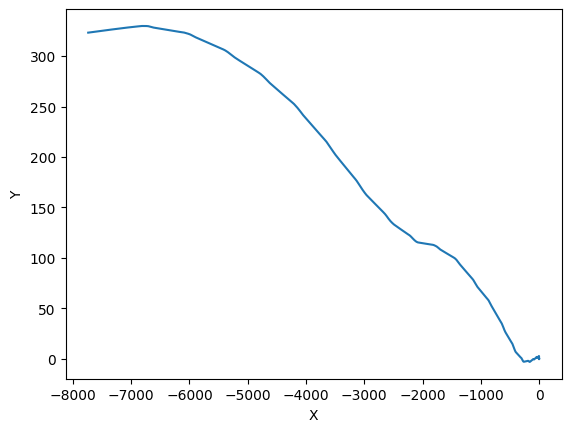

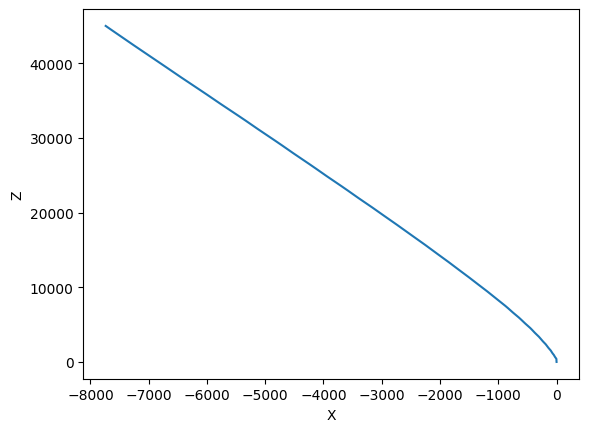

In [5]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import GaitTrackingKineticsProcedure

procedure = GaitTrackingKineticsProcedure()
WalkingKinematicsFilter(walking.m_IMU["LeftLeg"], procedure).run()

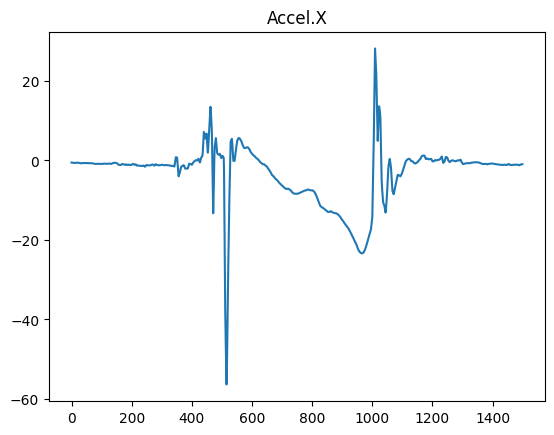

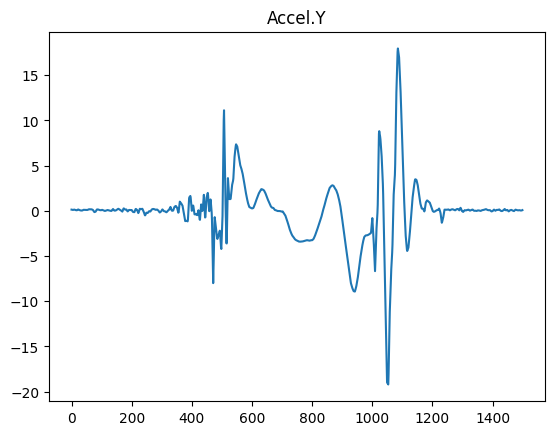

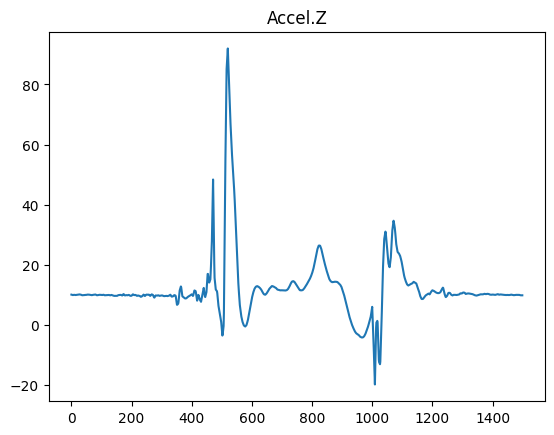

In [15]:
for axe in ["Accel.X", "Accel.Y", "Accel.Z"]:
    plt.figure()
    plt.title(axe)
    plt.plot(walking.m_IMU["LeftLeg"].data[axe][2000:3500])
    plt.show()